# Manifesto Analysis
Here we analyze the parties' manifestos.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Variables
### Parties and elections

In [22]:
parties = {'union': 'Union',
         'spd': 'SPD',
         'afd': 'AfD',
         'fdp': 'FDP',
         'linke': 'Die Linke',
         'grüne': 'Die Grünen'}
elections = ['bt', 'eu']

### Colors

In [23]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Methods

### Cleaning and tokenization

2. Replaces `<letter>-<letter>` by `<letter><letter>`
2. Replaces `<letter>*<letter>` by `<letter><letter>`
3. Replaces `<non-words>-<newline><non-words>` by nothing
4. Replaces `<non-words><newline><non-words>` by single space
5. Replaces `<non-words>` by single space

In [24]:
import re

def clean_and_tokenize(text, remove_numbers=False):
    if remove_numbers:
        replaced = re.sub(r'\d+', ' ', text)
    else:
        replaced = text
    replaced = re.sub(r'(\w)-(\w)', r'\1\2', replaced)
    replaced = re.sub(r'(\w)\*(\w)', r'\1\2', replaced)
    replaced = re.sub(r'\W*-\\n\W*', '', replaced)
    replaced = re.sub(r'\W*\\n\W*', ' ', replaced)
    replaced = re.sub(r'\W+', ' ', replaced)
    return replaced.split()

### Stop words


In [25]:
from nltk.corpus import stopwords

stop = set(stopwords.words('german'))

def test_stop_word(word):
    return (word.lower() in stop) or (word.capitalize() in stop)

### Dictionary

In [26]:
from enchant import Dict

dic = Dict("de_DE")

def test_dictionary(word):
    return dic.check(word.lower()) or dic.check(word.capitalize())

### Lemmatization
#### Spacy lemmatizer

In [27]:
from spacy.lang.de import lemmatizer

def lemmatize_spacy(word):
    try:
        return lemmatizer.LOOKUP[word]
    except: pass
    
    # Try to lemmatize lower word version
    try:
        return lemmatizer.LOOKUP[word.lower()]
    except: pass
    
    # Try to lemmatize capitalized word version
    try:
        return lemmatizer.LOOKUP[word.capitalize()]
    except: pass

#### Treetagger lemmatizer

In [28]:
from treetaggerwrapper import TreeTagger

tagger = TreeTagger(TAGLANG='de')

def lemmatize_tt(word):
    
    def lemmatize(w):
        tt_lower = tagger.tag_text([w], tagonly=True)[0].split('\t')[-1]
        if tt_lower != w:
            return tt_lower.split("|")[-1]
    
    lem = lemmatize(word)
    if lem is not None:
        return lem
    
    # Try to lemmatize lower word version
    lem = lemmatize(word.lower())
    if lem is not None:
        return lem
    
    # Try to lemmatize capitalized word version
    lem = lemmatize(word.capitalize())
    if lem is not None:
        return lem

#### Lemmatizer combiner
- If one lemmatizer exclusively modifies the word, it returns this lemmatized version
- If both lemmatizer modify the word, it returns the spaCy version
- If neither one modifies the word, it returns just the word

In [29]:
def lemmatize_combined(word):
    sp = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if sp is not None:
        return sp
    elif tt is not None:
        return tt
    else:
        return word

### Visualization

In [34]:
from matplotlib.ticker import MaxNLocator
from itertools import chain
from IPython.display import display_html

def plot_compare_bar(bt_data, eu_data, label):
    """ Returns a figure where two grouped DataFrames are compared in a bar chart.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties.values(), [bt_data[key] for key in bt_data], color=color_map_dark, width=-.4, align='edge', label='Bundestag election')
    ax.bar(parties.values(), [eu_data[key] for key in eu_data], color=color_map_light, width=.4, align='edge', label='European election')
    return fig


def generate_wordcloud(weight_matrix, title, number_of_words=30):
    """ The following function takes a weight matrix as an input with parties as columns and words as indices.
    """
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    plt.suptitle(title, size=25, weight='bold')
    axis = chain.from_iterable(zip(*axs))
    for party, ax in zip(weight_matrix.columns, axis):
        # Visuals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(party.upper(), size=20)
        color_func = lambda *args, **kwargs: colors[party]
        # Weights and Clourd
        word_weights = top_n(weight_matrix, party, number_of_words).iloc[:,0].to_dict()
        word_cloud = WordCloud(background_color='white', height=500, width=1000, color_func=color_func)
        image = word_cloud.generate_from_frequencies(word_weights)
        ax.imshow(image, interpolation='bilinear')
    return fig

        
def display_side_by_side(*args):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]

### Corpus

Loads political manifestos and extracts text using [pdftotext](https://github.com/jalan/pdftotext).

In [31]:
import pdftotext

def get_pdf_text(party, election):
    with open("../rsc/wahlprogramme/{0}_{1}.pdf".format(party, election), "rb") as f:
        pdf = pdftotext.PDF(f)
        return " ".join(pdf)
    

def merged_corpus(party, election, 
                  filters=[], 
                  lemmatize=True, 
                  lowercase=True, 
                  min_chars=0):
    # Fetch relevant data
    if election == 'all':
        raw_text = ' '.join([get_pdf_text(party, e) for e in elections])
    else:
        raw_text = get_pdf_text(party, election)
        
    # Cleaning & tokenization
    tokens = clean_and_tokenize(raw_text)
    
    filtered_tokens = []
    for token in tokens:
        # Min char removal
        if len(token) < min_chars:
            continue
            
        # Stop word removal
        if test_stop_word(token):
            continue
            
        # Additional filters 
        if not all(f(token) for f in filters):
            continue 
            
        # Lemmatization
        lem_token = token
        if lemmatize:
            lem_token = lemmatize_combined(token)
        
        # Lowercasing
        if lowercase:
            lem_token = lem_token.lower()
            
        filtered_tokens.append(lem_token)
        
    return filtered_tokens

## Plotting
### Get corpus

In [32]:
corpus_bt = {party: merged_corpus(party, 'bt', min_chars=4) for party in parties}
corpus_eu = {party: merged_corpus(party, 'eu', min_chars=4) for party in parties}

### Manifesto size

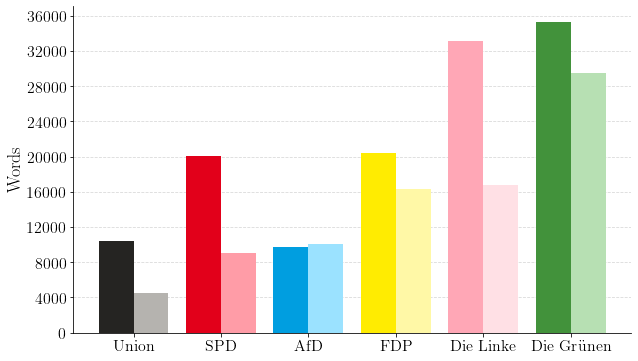

In [36]:
bt_size = {party: len(corpus_bt[party]) for party in parties}
eu_size = {party: len(corpus_eu[party]) for party in parties}
fig = plot_compare_bar(bt_size, eu_size, "Words")
fig.savefig('outputs/manifesto-word-count.pdf', bbox_inches = 'tight', pad_inches = 0)

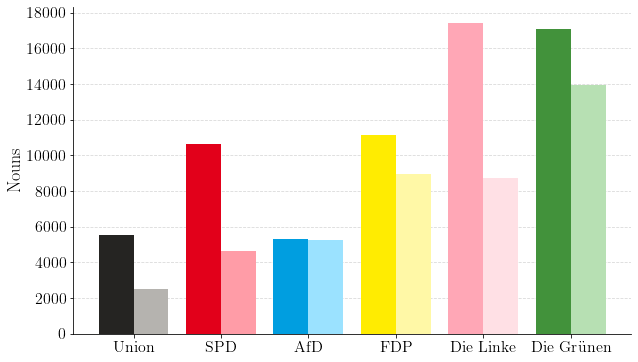

In [37]:
bt_nouns_size = {party: len(merged_corpus(party, 'bt', filters=[str.istitle], lemmatize=False, min_chars=3)) for party in parties}
eu_nouns_size = {party: len(merged_corpus(party, 'eu', filters=[str.istitle], lemmatize=False, min_chars=3)) for party in parties}
fig = plot_compare_bar(bt_nouns_size, eu_nouns_size, "Nouns")
fig.savefig('outputs/manifesto-noun-count.pdf', bbox_inches = 'tight', pad_inches = 0)

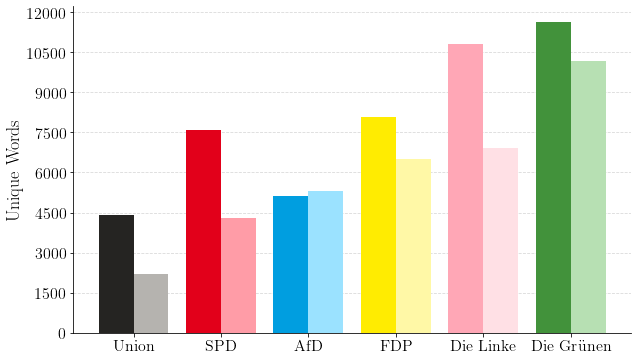

In [38]:
bt_distinct_nouns_size = {party: len(set(merged_corpus(party, 'bt', lemmatize=False, min_chars=3))) for party in parties}
eu_distinct_nouns_size = {party: len(set(merged_corpus(party, 'eu', lemmatize=False, min_chars=3))) for party in parties}
fig = plot_compare_bar(bt_distinct_nouns_size, eu_distinct_nouns_size, "Unique Words")
fig.savefig('outputs/manifesto-unique-word-count.pdf', bbox_inches = 'tight', pad_inches = 0)

### Topic analysis
#### tf-idf

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_bt = TfidfVectorizer(lowercase=False, sublinear_tf=True)
x_bt = v_bt.fit_transform(" ".join(corpus_bt[party]) for party in parties)
df_bt = pd.DataFrame(x_bt.T.toarray(), index=v_bt.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_bt, party, 20) for party in parties))

,union
wahlperiode,0.049826
deutschland,0.045075
verlässlichkeit,0.043571
marshallplan,0.043571
ballungsraum,0.042164
land,0.041977
gut,0.040164
mensch,0.039983
neu,0.038687
card,0.038465


In [40]:
v_eu = TfidfVectorizer(lowercase=False, sublinear_tf=True)
x_eu = v_eu.fit_transform(" ".join(corpus_eu[party]) for party in parties)
df_eu = pd.DataFrame(x_eu.T.toarray(), index=v_eu.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_eu, party, 20) for party in parties))

,union
europa,0.072382
europäisch,0.062472
stabilitätsunion,0.059103
champions,0.059103
westen,0.056701
zukunftsprojekt,0.052998
gemeinsam,0.052347
manfred,0.051978
transitzentren,0.051978
stiften,0.051978


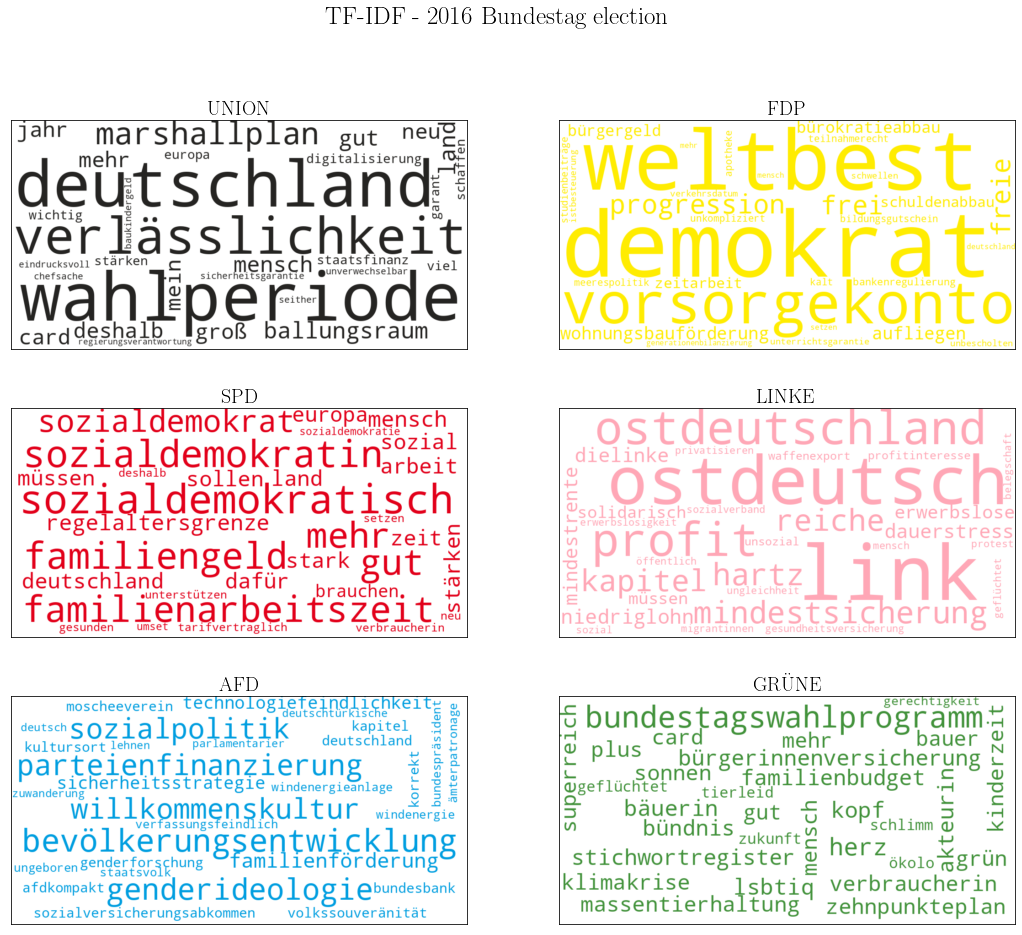

In [41]:
from wordcloud import WordCloud

fig = generate_wordcloud(df_bt, 'TF-IDF - 2016 Bundestag election')
fig.savefig('outputs/manifesto-tfidf-wordcloud-bt.pdf', bbox_inches = 'tight', pad_inches = 0)

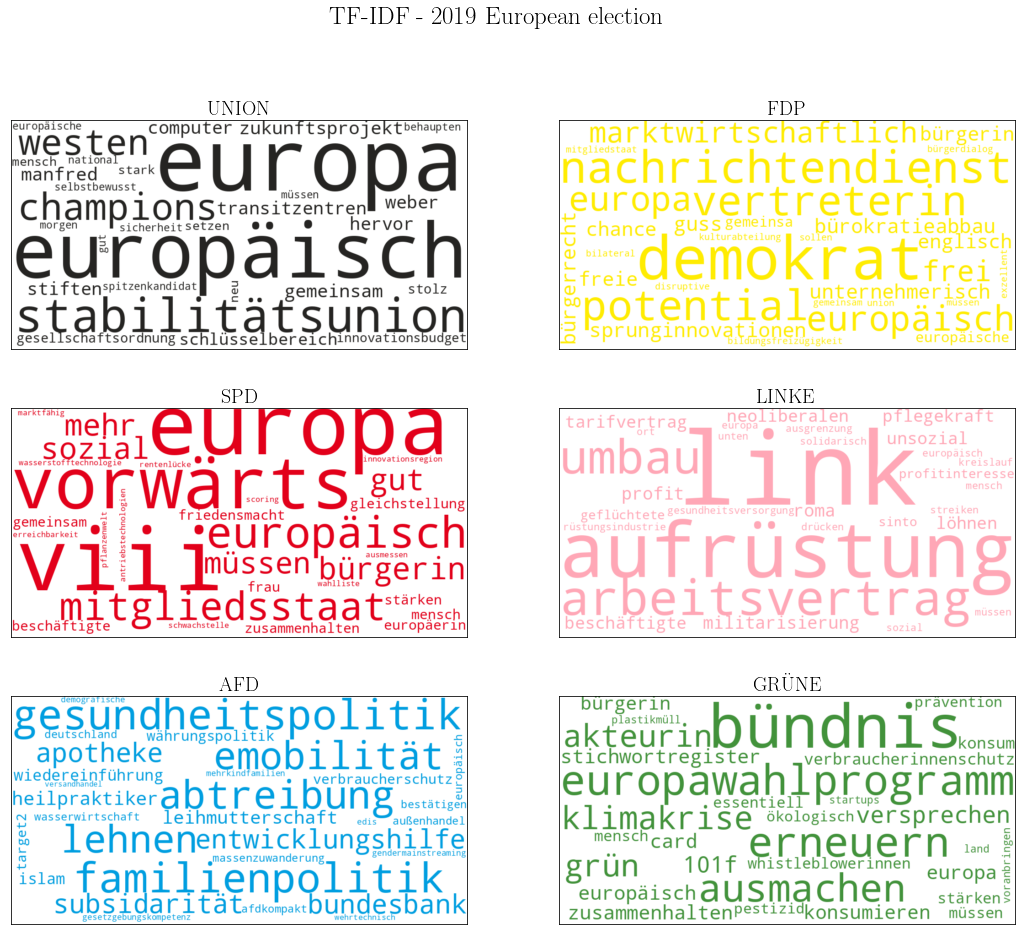

In [42]:
fig = generate_wordcloud(df_eu, 'TF-IDF - 2019 European election')
fig.savefig('outputs/manifesto-tfidf-wordcloud-eu.pdf', bbox_inches = 'tight', pad_inches = 0)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

v_bt = TfidfVectorizer(lowercase=False, sublinear_tf=True)
x_bt = v_bt.fit_transform(" ".join(corpus_bt[party]) for party in parties)
df_bt = pd.DataFrame(x_bt.T.toarray(), index=v_bt.get_feature_names(), columns=parties)
display_side_by_side(*(top_n(df_bt, party, 20) for party in parties))

,union
wahlperiode,0.049826
deutschland,0.045075
verlässlichkeit,0.043571
marshallplan,0.043571
ballungsraum,0.042164
land,0.041977
gut,0.040164
mensch,0.039983
neu,0.038687
card,0.038465
